# Process Crow et al. data
This notebook does the following:

1. Select template experiment. This template experiment will be used in the next [notebook](2_identify_generic_genes_pathways.ipynb) to simulate experiments with the same experimental design but testing a different biological process.

2. Crow et al. data was downloaded using `explore_RNAseq_only_generic_genes/download_Crow_data.R` script that downloads expression data from https://github.com/PavlidisLab/gemmaAPI.R

Note: For the analysis exploring the RNA-seq only common DEGs we used the union of genes per experiment, which resulted in some samples having NaNs for some samples. For this analysis we are taking the intersection so that we can remove all NaNs to train.

3. Train VAE on processed data.

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Set seeds to get reproducible VAE trained models
process.set_all_seeds()

### Set parameters for data processing

Most parameters are read from `config_filename`. We manually selected bioproject [GSE11352](https://www.ncbi.nlm.nih.gov/gds/?term=GSE11352[Accession]) as the template experiment, which contains breast cell lines treated with estradiol at 12H, 24H and 48H.

In [3]:
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

# Read in config variables
config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human_Crow.tsv")
)

params = utils.read_config(config_filename)

local_dir = params["local_dir"]
dataset_name = params["dataset_name"]

# File that contains gene ranks identified by Crow et. al.
DE_prior_filename = params["reference_gene_filename"]

# Template experiment ID
project_id = params["project_id"]

# Column name containing sample ids
metadata_colname = params["metadata_colname"]

# Output file: pickled list of shared genes(generated during gene ID mapping)
shared_genes_filename = params["shared_genes_filename"]

# Output files of template experiment data
mapped_template_filename = params["mapped_template_filename"]
processed_template_filename = params["processed_template_filename"]

# Output files of Rani's compendium data
raw_compendium_filename = params["raw_compendium_filename"]
mapped_compendium_filename = params["mapped_compendium_filename"]
normalized_compendium_filename = params["normalized_compendium_filename"]

# Output file: pickled scaler (generated during compendium normalization)
scaler_filename = params["scaler_filename"]

### Load compendium data

[Gemma](https://pavlidislab.github.io/Gemma/) contains nearly 4K expression profiling studies/datasets. The data comes from different platforms, including array and RNA-seq platforms. To enable comparisons across platforms, we perform sequence analysis and gene assignment based on the current genome annotations: https://pubmed.ncbi.nlm.nih.gov/16237126/

Data was normalized using RMA, which outputs log2 transformed data: https://pubmed.ncbi.nlm.nih.gov/12925520/. Positive logFC indicate the logarithmic foldness of UPregulation. Negative logFC indicate the logarithmic foldness of DOWNregulation

In [4]:
raw_compendium = pd.read_csv(raw_compendium_filename, sep="\t", header=0, index_col=0)
print(raw_compendium.shape)
raw_compendium.head()

(32476, 14487)


,HSPA6|HSPA7,UBA7,ESRRA,CYP2A7|CYP2A6,ADAM32,CORO6,CCDC65,LEAP2,CTCFL,C4orf33,...,TRIM15,NBL1|MICOS10-NBL1,GRK2,ATN1,FBXO41,KCTD13,TFEB,DND1,CASKIN2,GIMAP1-GIMAP5|GIMAP5
L_IB38___BioAssayId=72907Name=050705MJA_U133_2.0_IB08.CEL,8.96564,83.32761,48.94783,6.05333,17.74886,177.35550,22.08059,24.29061,NaN,57.44873,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB40___BioAssayId=72909Name=050705MJA_U133_2.0_IB10.CEL,769.30450,61.90878,119.33116,17.42643,11.58205,117.40292,46.72446,50.81827,4.21085,29.51632,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB41___BioAssayId=72910Name=050705MJA_U133_2.0_IB11.CEL,23.69639,93.37774,80.67838,27.73698,18.56551,175.07208,21.01308,56.90577,4.52370,70.19458,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB33___BioAssayId=72902Name=050705MJA_U133_2.0_IB03.CEL,10.37628,56.58948,64.83450,14.86978,8.71849,41.07041,24.34623,62.00211,12.89886,38.07436,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
L_IB36___BioAssayId=72905Name=050705MJA_U133_2.0_IB06.CEL,48.51214,41.29277,76.53021,15.66673,5.35315,27.70762,4.19627,13.33500,0.54027,14.19567,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [30]:
# Are there any negative values in the raw downloaded data
# Expression data was downloaded from GEMMA (https://gemma.msl.ubc.ca/home.html)
# Description for how the data was processed can be found: https://pavlidislab.github.io/Gemma/curation.html
# Looks like there are some negative values in the raw downloaded data.
# Possibly from the log transform
tmp = raw_compendium[(raw_compendium < 0).any(axis=1)]
tmp2 = tmp.loc["GSE12108_Biomat_8___BioAssayId=46616Name=SchuS4infectedD8_S4"]
tmp2[tmp2 < 0]

KeyError: 'GSE12108_Biomat_8___BioAssayId=46616Name=SchuS4infectedD8_S4'

### Process compendium data

1. Drop probe column
2. Transpose
3. Get only shared genes from Crow et. al.
4. Normalize

I manually looked up GSE experiment ids with ~3K - ~9K NA genes using gemma.msl.ubc.ca. These experiments were all using the  GPL570 (Affymetrix Human Genome U133 Plus 2.0 Array) platform described in [Crow et al.](https://www.pnas.org/content/116/13/6491).

Some examples:
* https://gemma.msl.ubc.ca/expressionExperiment/showExpressionExperiment.html?id=3195
* https://gemma.msl.ubc.ca/expressionExperiment/showExpressionExperiment.html?id=7470
* https://gemma.msl.ubc.ca/expressionExperiment/showExpressionExperiment.html?id=7934

If i look up the genes that have NA, it says there is "no data" though I'm not sure what is causing this. So for now I will try to remove as many of the NAs as I can with filtering.

In [5]:
# Matrix is sample x gene
# Note, there are NaNs in the matrix. I'm not exactly sure what is causing this since the data
# downloaded was based on what Crow et al used in their analysis and therefore should have been
# filtered by platform.

# Filter out samples that are all NaNs ***
samples_to_drop = raw_compendium[
    raw_compendium.isna().sum(axis=1) == raw_compendium.shape[1]
].index
processed_compendium = raw_compendium.drop(samples_to_drop)

# All genes have at least 1 NaN so dropping all genes with NaN removes all the data
# Instead we will move genes if they are NaN in _most_ samples (>90%)
x = processed_compendium.isna().sum()
processed_compendium = processed_compendium[x.index[x < 100]]

# Remove remaining samples with NaNs
processed_compendium = processed_compendium[processed_compendium.isna().sum(axis=1) < 1]

assert processed_compendium.isna().sum().sum() == 0

In [6]:
# Log transformed the data since the spread is very large
# If we do not log10 transform the data, the few very samples with very large expression values
# will be the dominant signal that will drown out the small signals in the data
# Depending on the biological interest of these large expression signals we can choose to process the
# data differently. In this case, since we are looking at the data wholistically we will use the
# log10 transform of the data here.
processed_compendium_transform = np.log10(processed_compendium)

# Replace -inf (from 0 input) and nans (from negative values) with 0
# Negatives probably created from taking the log of very small values
# Normalization performed using RMA
processed_compendium_transform = processed_compendium_transform.replace(
    -np.inf, 0.0
).replace(np.nan, 0.0)

assert processed_compendium_transform.isna().sum().sum() == 0

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log10
  


In [7]:
# Get only gene expression data for genes in Crow et. al.
our_gene_ids_hgnc = list(processed_compendium_transform.columns)

published_generic_genes = process.get_published_generic_genes(DE_prior_filename)
shared_genes_hgnc = list(set(our_gene_ids_hgnc).intersection(published_generic_genes))

# In Python, the order of elements in a list that is converted from a set
# is non-deterministic, so it is sorted here to have reproducible result.
shared_genes_hgnc.sort()

# Pickle `shared_genes_hgnc` and save as `shared_genes_filename`
if not os.path.exists(shared_genes_filename):
    with open(shared_genes_filename, "wb") as pkl_fh:
        pickle.dump(shared_genes_hgnc, pkl_fh)

mapped_compendium = processed_compendium_transform[shared_genes_hgnc]

assert mapped_compendium.isna().sum().sum() == 0

print(mapped_compendium.shape)
mapped_compendium.head(10)

(32082, 7130)


,A1BG,A2M,A2M-AS1,A2ML1,A4GNT,AA06,AAAS,AACS,AADAC,AADACL2,...,ZSCAN9,ZSWIM1,ZSWIM3,ZSWIM5,ZSWIM6,ZW10,ZWINT,ZXDA,ZXDB,ZYG11A
GSE10063_Biomat_7___BioAssayId=163892Name=ControlSample630min,0.571601,0.598590,0.520385,0.794148,0.591038,0.615371,0.910425,0.965449,0.566881,0.489531,...,0.835300,0.866592,0.784614,0.590304,0.951766,0.928338,1.027752,0.724402,0.865850,0.660619
GSE10063_Biomat_32___BioAssayId=163897Name=ControlSample530min,0.539147,0.618073,0.535924,0.754949,0.598154,0.655132,0.902333,0.961865,0.551213,0.505177,...,0.832044,0.867172,0.796381,0.595714,0.954047,0.930259,1.026099,0.698344,0.867616,0.682210
GSE10063_Biomat_28___BioAssayId=163902Name=ControlSample430min,0.522899,0.631482,0.534423,0.776558,0.606852,0.647739,0.916293,0.962574,0.554331,0.514534,...,0.836911,0.880463,0.778897,0.556841,0.964041,0.926184,1.028900,0.719451,0.864730,0.703690
GSE10063_Biomat_26___BioAssayId=163907Name=ControlSample330min,0.563810,0.588201,0.540530,0.776717,0.627376,0.599687,0.911394,0.966741,0.570926,0.511841,...,0.834422,0.872813,0.796994,0.559478,0.958190,0.928594,1.026675,0.690117,0.862898,0.673528
GSE10063_Biomat_39___BioAssayId=163912Name=ControlSample230min,0.540305,0.605917,0.548969,0.783253,0.603126,0.621750,0.910051,0.961996,0.575308,0.535309,...,0.841115,0.875508,0.805288,0.574399,0.954886,0.929532,1.025895,0.728495,0.859196,0.704910
GSE10063_Biomat_42___BioAssayId=163917Name=ControlSample130min,0.492827,0.613677,0.508108,0.768256,0.599115,0.629805,0.921272,0.962898,0.569719,0.535819,...,0.847717,0.891253,0.801639,0.598343,0.949609,0.925918,1.023246,0.713836,0.865543,0.660988
GSE10063_Biomat_9___BioAssayId=163890Name=ControlSample66hr,0.556978,0.598097,0.506869,0.775407,0.603353,0.612550,0.909354,0.959400,0.591771,0.499302,...,0.837329,0.861435,0.805133,0.595730,0.948180,0.932950,1.024011,0.687187,0.867712,0.677885
GSE10063_Biomat_3___BioAssayId=163895Name=ControlSample56hr,0.554500,0.572903,0.537850,0.755464,0.611754,0.634280,0.913380,0.963798,0.578438,0.519282,...,0.840915,0.873723,0.803598,0.605943,0.944110,0.931135,1.024294,0.703586,0.865467,0.664662
GSE10063_Biomat_33___BioAssayId=163900Name=ControlSample46hr,0.537069,0.622554,0.538115,0.779098,0.631912,0.615186,0.912124,0.971920,0.610340,0.506764,...,0.845760,0.874079,0.803127,0.598248,0.944240,0.923332,1.017829,0.680830,0.866404,0.662673
GSE10063_Biomat_22___BioAssayId=163905Name=ControlSample36hr,0.551253,0.591193,0.512460,0.764557,0.599550,0.640611,0.913201,0.965070,0.583571,0.499605,...,0.854596,0.877972,0.798415,0.603895,0.943943,0.924270,1.024572,0.690554,0.870708,0.680183


In [8]:
# Save
mapped_compendium.to_csv(mapped_compendium_filename, sep="\t")

In [9]:
# Normalize data
process.normalize_compendium(
    mapped_compendium_filename, normalized_compendium_filename, scaler_filename
)

In [10]:
# Check normalized data values
normalized_compendium = pd.read_csv(
    normalized_compendium_filename, sep="\t", index_col=0
)

In [11]:
normalized_compendium.head(10)

,A1BG,A2M,A2M-AS1,A2ML1,A4GNT,AA06,AAAS,AACS,AADAC,AADACL2,...,ZSCAN9,ZSWIM1,ZSWIM3,ZSWIM5,ZSWIM6,ZW10,ZWINT,ZXDA,ZXDB,ZYG11A
GSE10063_Biomat_7___BioAssayId=163892Name=ControlSample630min,0.384,0.207,0.462,0.607,0.438,0.417,0.276,0.366,0.494,0.647,...,0.333,0.268,0.264,0.343,0.266,0.264,0.447,0.306,0.369,0.423
GSE10063_Biomat_32___BioAssayId=163897Name=ControlSample530min,0.377,0.211,0.464,0.600,0.440,0.426,0.274,0.366,0.491,0.649,...,0.333,0.268,0.267,0.344,0.267,0.264,0.447,0.300,0.369,0.427
GSE10063_Biomat_28___BioAssayId=163902Name=ControlSample430min,0.374,0.213,0.464,0.604,0.442,0.424,0.277,0.366,0.492,0.650,...,0.334,0.271,0.262,0.335,0.269,0.263,0.447,0.305,0.369,0.431
GSE10063_Biomat_26___BioAssayId=163907Name=ControlSample330min,0.382,0.205,0.465,0.604,0.446,0.414,0.276,0.367,0.494,0.650,...,0.333,0.269,0.267,0.336,0.267,0.264,0.447,0.298,0.368,0.425
GSE10063_Biomat_39___BioAssayId=163912Name=ControlSample230min,0.377,0.208,0.466,0.605,0.441,0.418,0.276,0.366,0.495,0.654,...,0.335,0.270,0.269,0.339,0.267,0.264,0.447,0.307,0.368,0.432
GSE10063_Biomat_42___BioAssayId=163917Name=ControlSample130min,0.367,0.210,0.460,0.602,0.440,0.420,0.279,0.366,0.494,0.654,...,0.337,0.274,0.268,0.345,0.266,0.263,0.447,0.304,0.369,0.423
GSE10063_Biomat_9___BioAssayId=163890Name=ControlSample66hr,0.381,0.207,0.460,0.603,0.441,0.416,0.275,0.365,0.498,0.648,...,0.334,0.266,0.269,0.344,0.265,0.265,0.447,0.297,0.369,0.426
GSE10063_Biomat_3___BioAssayId=163895Name=ControlSample56hr,0.380,0.202,0.465,0.600,0.443,0.421,0.276,0.366,0.496,0.651,...,0.335,0.270,0.269,0.347,0.265,0.265,0.447,0.301,0.369,0.424
GSE10063_Biomat_33___BioAssayId=163900Name=ControlSample46hr,0.377,0.212,0.465,0.604,0.447,0.417,0.276,0.368,0.501,0.649,...,0.336,0.270,0.269,0.345,0.265,0.263,0.446,0.295,0.369,0.423
GSE10063_Biomat_22___BioAssayId=163905Name=ControlSample36hr,0.379,0.205,0.461,0.602,0.440,0.423,0.276,0.366,0.497,0.648,...,0.338,0.271,0.267,0.346,0.265,0.263,0.447,0.298,0.370,0.427


In [ ]:
# Check that there are no negative values

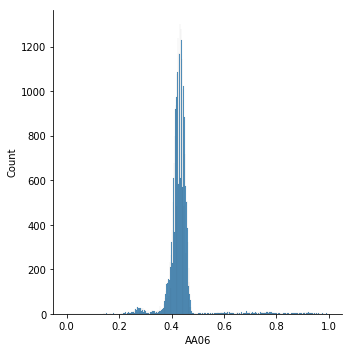

In [13]:
sns.displot(normalized_compendium["AA06"])

### Select and process template data

1. Get gene expression associated with `project_id`, which was manually selected by the user and specified in the config file.

Note: The data is not normalized so that we can perform DE analysis in next notebook

In [16]:
# Note: This is the only notebook using this function, so for now it is included here
# Get sample ids associated with selected project id
def get_sample_ids(experiment_id, mapping_filename):
    """
    Return sample ids for a given experiment id

    """
    # Read in metadata
    metadata = pd.read_csv(mapping_filename, header=0)
    metadata.set_index("Experiment id", inplace=True)

    selected_metadata = metadata.loc[experiment_id]
    sample_ids = list(selected_metadata[metadata_colname])

    return sample_ids


# metadata file with mapping from experiment to sample
experiment_to_sample_metadata_filename = os.path.join(
    base_dir, dataset_name, "data", "metadata", "experiment_sample_annotations.csv"
)

sample_ids = get_sample_ids(project_id, experiment_to_sample_metadata_filename)

# Get expression data
template_mapped = mapped_compendium.loc[sample_ids]
print(template_mapped.shape)

# Save
template_mapped.to_csv(mapped_template_filename, sep="\t")

(36, 7130)


### Train VAE

In [17]:
# Create VAE directories if needed
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs"),
]

NN_architecture = params["NN_architecture"]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    sub_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(sub_dir, exist_ok=True)

input dataset contains 32082 samples and 7130 genes
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))



Train on 24062 samples, validate on 8020 samples
Epoch 1/10
24062/24062 [==============================] - 1483s 62ms/step - loss: 4512.3091 - val_loss: 30659.9617
Epoch 2/10
24062/24062 [==============================] - 1496s 62ms/step - loss: 4494.6940 - val_loss: 4501.5438
Epoch 3/10
24062/24062 [==============================] - 1500s 62ms/step - loss: 4489.1813 - val_loss: 4502.6172
Epoch 4/10
24062/24062 [==============================] - 1487s 62ms/step - loss: 4487.0675 - val_loss: 4489.3105
Epoch 5/10
24062/24062 [==============================] - 1487s 62ms/step - loss: 4485.7377 - val_loss: 4484.0348
Epoch 6/10
24062/24062 [==============================] - 1507s 63ms/step - loss: 4484.5476 - val_loss: 4526.6664
Epoch 7/10
24062/24062 [==============================] - 1500s 62ms/step - loss: 4483.4933 - val_loss: 4491.2723
Epoch 8/10
24062/24062 [==============================] - 1487s 62ms/step - loss: 4483.4762 - val_loss: 4485.2269
Epoch 9/10
24062/24062 [=============

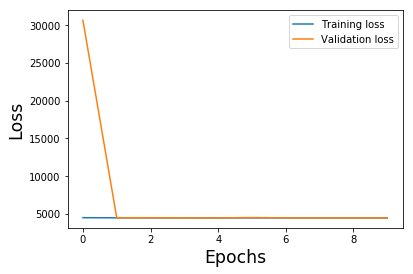

In [18]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_filename, normalized_compendium_filename)